In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from enterprise.signals.utils import powerlaw

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils, pair_covariance, orf_functions
from defiant.extra import mdc1_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
psrs,inj_params = mdc1_utils.get_mdc1_psrs()

pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [92]:
# Lets get the true covariance matrix (i.e. only HD)
x,r,s,C,a,a2s = OS_obj.compute_PFOS(inj_params,pair_covariance=True)
true_C = C[4]

# Now switch to MCOS
OS_obj.set_orf(['hd','dipole','monopole'])

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


### Next, we need to set it as a MCOS and get all of the elements of the MCOS

In [93]:
X,Z = OS_obj._compute_XZ(inj_params)
gw_signal = [s for s in OS_obj.pta._signalcollections[0] if s.signal_id==OS_obj.gwb_name][0]
phi = gw_signal.get_phi(inj_params)
rhok,sigk,normk = OS_obj._compute_rhok_sigk(X,Z,phi,False)
xi,_ = utils.compute_pulsar_pair_separations(OS_obj.psrs, OS_obj._pair_idx)


problem_freq = 4
ORF = OS_obj._orf_matrix
design = OS_obj.orf_design_matrix

Sk = phi[problem_freq*2]

phi1 = np.zeros( shape=(len(OS_obj.freqs)) )  
phi1[problem_freq] = 1
phi1 = np.repeat(phi1,2)

phi2 = phi/Sk

### In order to get the covariance matrix, we need to assume things, so lets define a function so we can change it

In [94]:
from tqdm import tqdm
def compute_mcos_pair_covariance(Z, phi1, phi2, orf, design, 
                                  rho_ab, sig_ab, norm_ab, a2_est,
                                  use_tqdm, max_chunk, iterations):
    
    # Need to compute the a no-PC MCOS for amp estimates
    temp_c = np.square(sig_ab)
    mcos,_ = utils.linear_solve(design,temp_c,rho_ab,'diagonal')

    # Now lets iterate
    iterable = tqdm(range(iterations)) if use_tqdm else range(iterations)
    for i in iterable:
        # Normalize the power per process
        norm_pow = mcos/np.sqrt(np.dot(mcos,mcos))
        est_pow = a2_est*norm_pow

        # Hijack the factored code by giving it correlated power in ORF and A2=1!
        cor_pow = np.sum([o*a for o,a in zip(orf,est_pow)], axis=0)

        fact_c = pair_covariance._factored_pair_covariance(Z,phi1,phi2,cor_pow,norm_ab,False,max_chunk)

        if i<iterations-1:
            # Now we need to update the MCOS
            temp_c = np.array((fact_c[0],fact_c[1]+fact_c[2]))
            mcos,_ = utils.linear_solve(design,temp_c,rho_ab,'woodbury')
            
    return np.array(( fact_c[0], fact_c[1] + fact_c[2] ))


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/utils.py:370: RuntimeWarning: invalid value encountered in sqrt
  sigavg[i] = np.abs(bin_orf)*np.sqrt(s2)


[-3.20713298e-15 -2.47279127e-15 -4.90628225e-16] 
 [[-5.90233791e-31 -9.85622887e-31  1.81207836e-31]
 [-9.85622887e-31  2.10112542e-30 -6.89467705e-32]
 [ 1.81207836e-31 -6.89467705e-32  4.78191144e-32]]


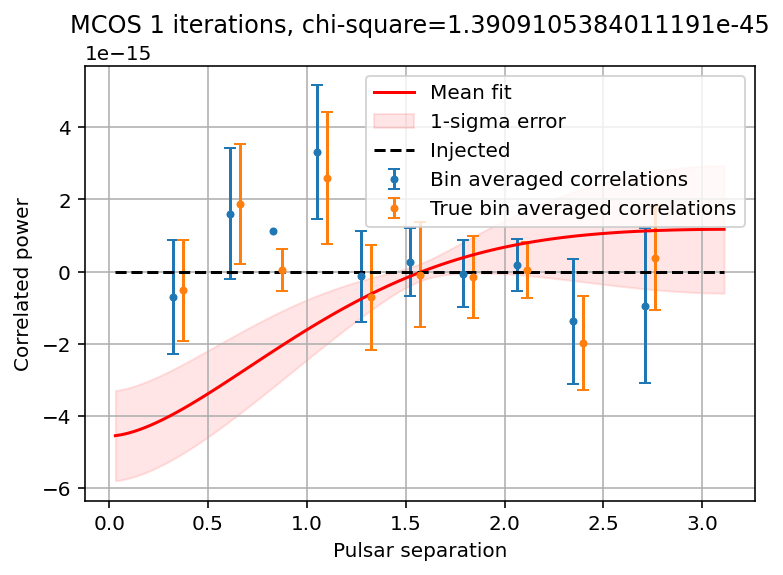

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


[-2.31879143e-12 -1.83314918e-13 -3.64412242e-13] 
 [[2.73128698e-28 2.21139267e-29 4.24326895e-29]
 [2.21139267e-29 2.10962079e-30 3.44860554e-30]
 [4.24326895e-29 3.44860554e-30 6.64712019e-30]]


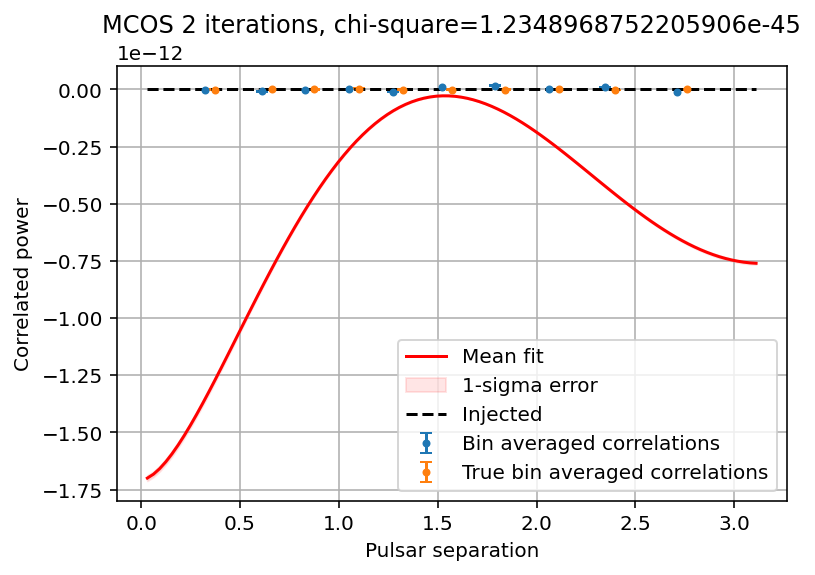

100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


[-8.53817821e-15 -1.08417916e-15  8.80000602e-17] 
 [[ 3.47658491e-30 -3.03255776e-31  2.21943900e-32]
 [-3.03255776e-31  3.08136882e-32  6.42970317e-32]
 [ 2.21943900e-32  6.42970317e-32  3.11163532e-32]]


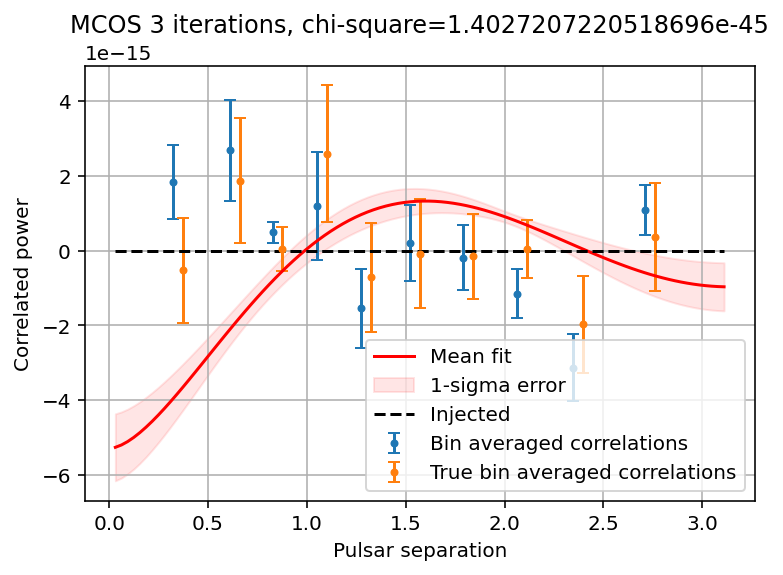

100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


[-4.24674038e-14  7.38346935e-15  4.61253515e-15] 
 [[ 2.31171170e-30  3.08269669e-31  3.89951106e-31]
 [ 3.08269669e-31 -3.46559641e-31  1.22544036e-31]
 [ 3.89951106e-31  1.22544036e-31 -2.12961124e-31]]


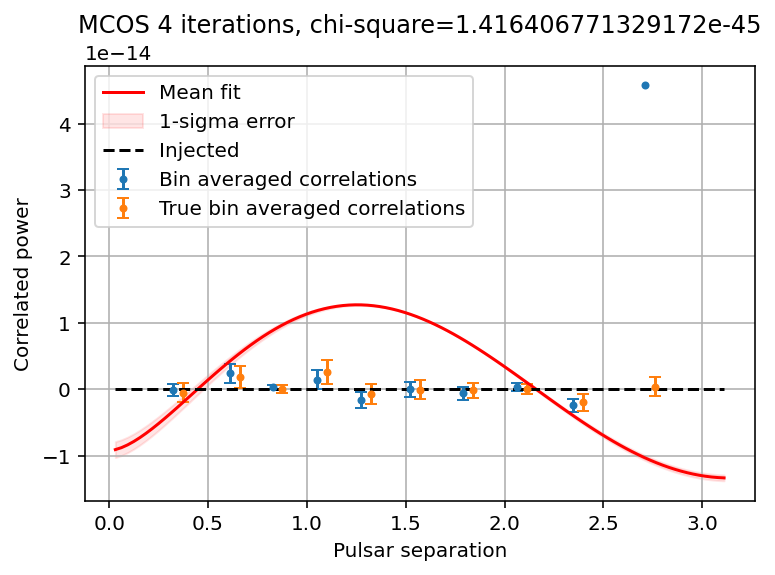

100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


[-1.52484139e-15  2.69508340e-15  3.59545254e-16] 
 [[ 1.22501360e-30 -1.43243284e-31 -8.45907565e-32]
 [-1.43243284e-31  4.54953949e-31 -5.22260985e-32]
 [-8.45907565e-32 -5.22260985e-32  1.61508852e-31]]


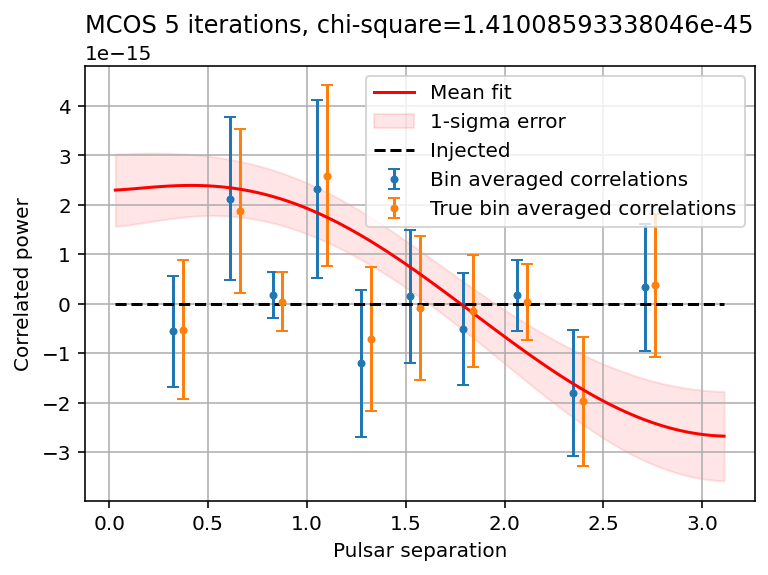

100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


[ 3.43794479e-15  1.09892263e-14 -1.31369429e-15] 
 [[ 7.02483159e-31  9.92548757e-32 -2.52574259e-32]
 [ 9.92548757e-32  3.30355948e-30 -4.35713415e-32]
 [-2.52574259e-32 -4.35713415e-32  1.75008086e-31]]


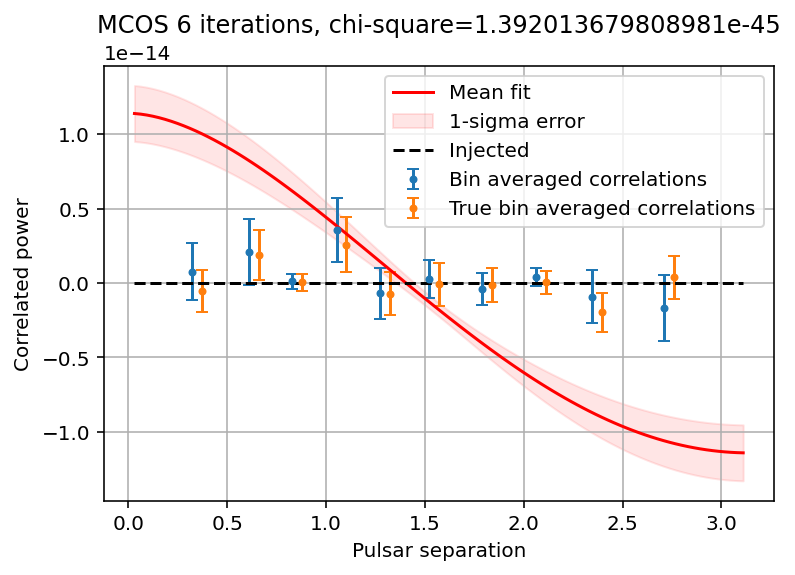

100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


[-4.02452839e-15  1.69361662e-15 -2.37232124e-16] 
 [[ 2.70421800e-30 -1.24283980e-30 -9.01273958e-32]
 [-1.24283980e-30  3.97184007e-30 -3.48297642e-32]
 [-9.01273958e-32 -3.48297642e-32  1.69983584e-32]]


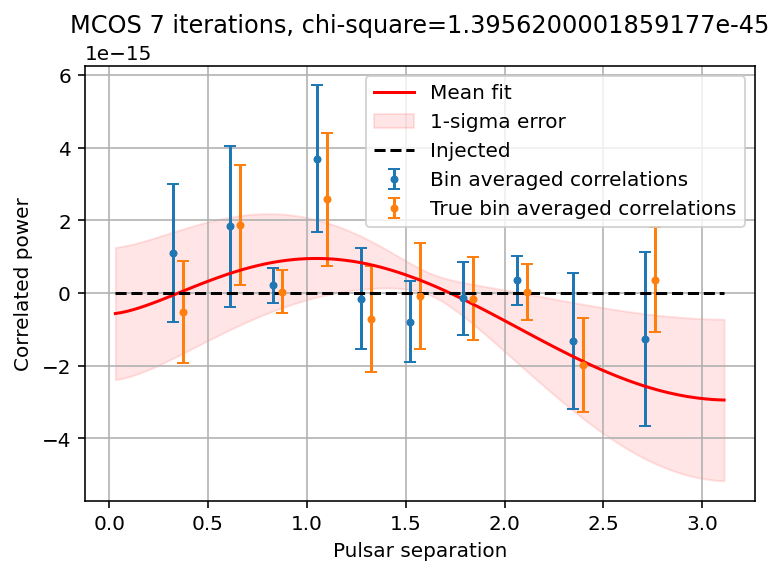

100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


[-3.78539466e-14  3.37137199e-15  5.31329994e-15] 
 [[ 3.03009801e-30 -1.45748084e-30 -3.65714001e-31]
 [-1.45748084e-30  1.19107308e-30  1.78558097e-31]
 [-3.65714001e-31  1.78558097e-31  1.16733939e-31]]


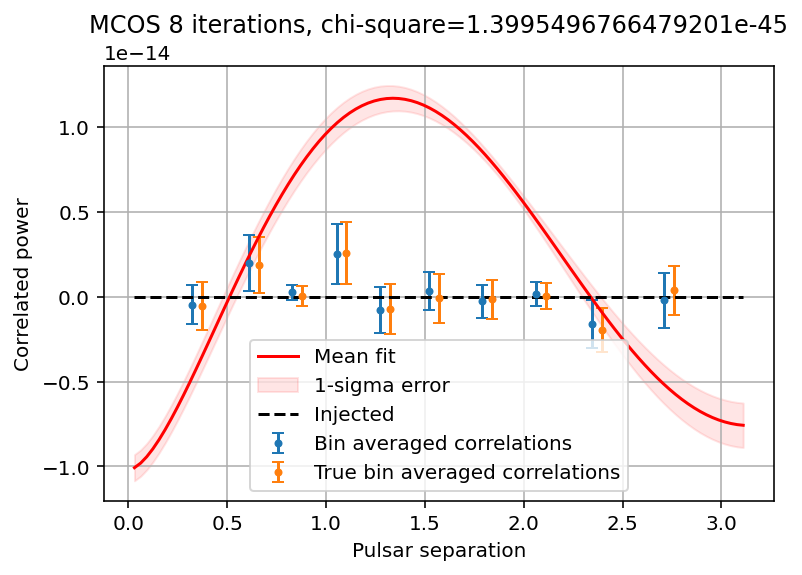

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


[-8.50493229e-16  2.11926064e-15  2.20147999e-16] 
 [[ 1.29486586e-30 -7.62329341e-32 -1.20152210e-31]
 [-7.62329341e-32  3.00601032e-31 -4.41475279e-32]
 [-1.20152210e-31 -4.41475279e-32  2.14666378e-31]]


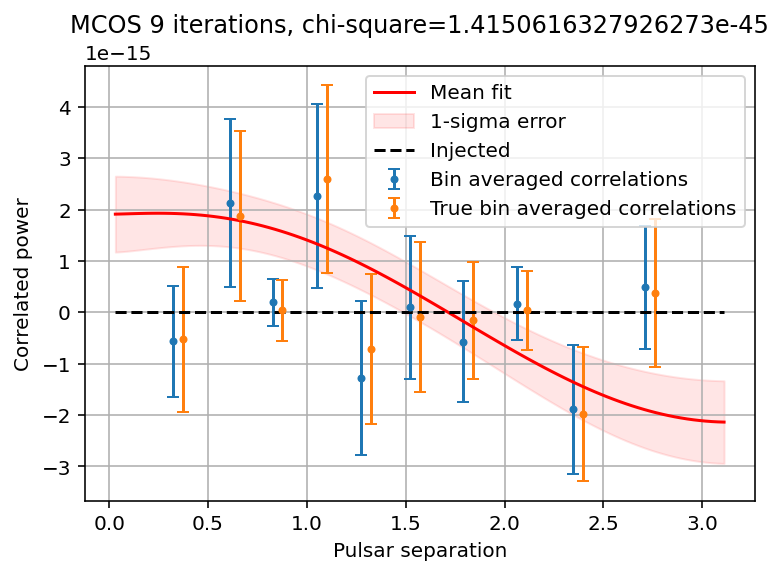

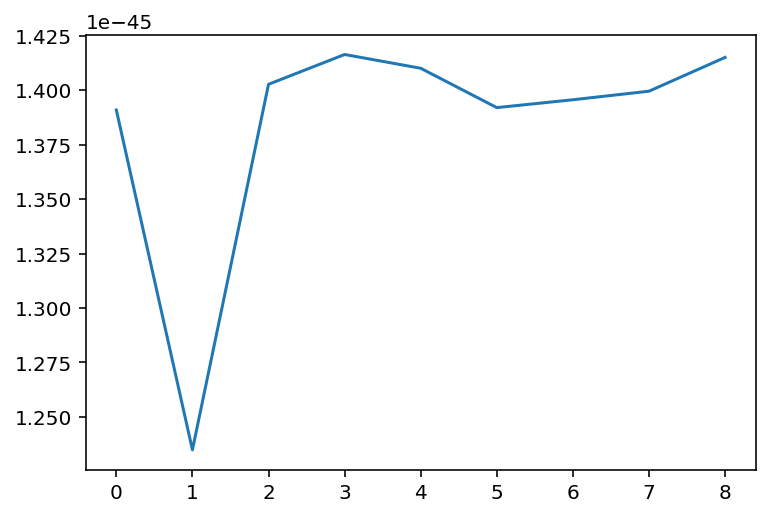

In [119]:
iter_chi2 = []
for i in range(1,10):
    C = compute_mcos_pair_covariance(Z, phi1, phi2, ORF, design, rhok[problem_freq], 
                             sigk[problem_freq], normk[problem_freq], Sk, True, 300, i)
    Ck = C[0] + C[1]
    A2,A2s = utils.linear_solve(design,C,rhok[problem_freq],'woodbury')
    print(A2,'\n',A2s)

    xi_range = np.linspace(0,np.pi,102)[1:-1]
    
    hd_mod = orf_functions.get_orf_function('hd')(xi_range)

    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],Ck,bins=10)
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')

    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],true_C,bins=10)
    plt.errorbar(xiBin+0.05,rhoBin,sigBin,fmt='.',capsize=3,label='True bin averaged correlations')

    cor_mean,cor_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,A2s,['hd','dipole','monopole'])
    plt.plot(xi_range,cor_mean,'-r',label='Mean fit')
    plt.fill_between(xi_range,(cor_mean-cor_sig),(cor_mean+cor_sig),color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

    chi2 = utils.chi_square(rhok[problem_freq],Ck,design,A2)
    iter_chi2.append(chi2)
    plt.title(f'MCOS {i} iterations, chi-square={chi2}')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

plt.plot(iter_chi2)

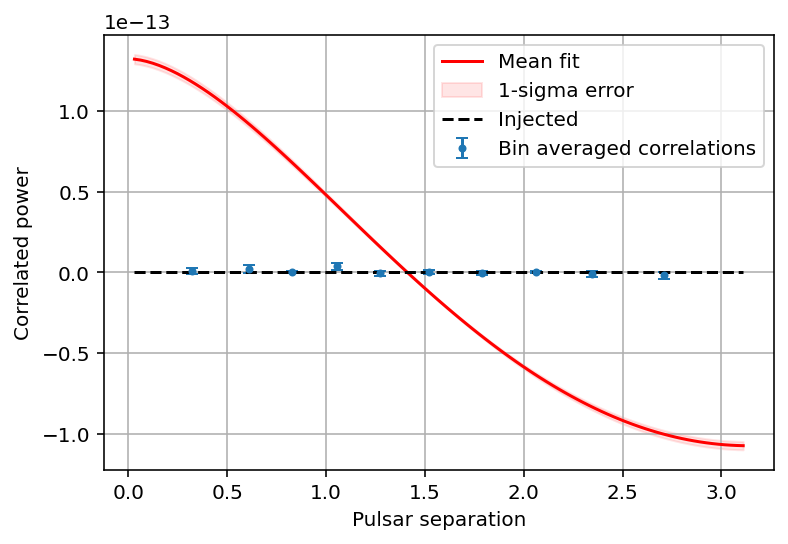

In [82]:
xi_range = np.linspace(0,np.pi,102)[1:-1]
hd_mod = orf_functions.get_orf_function('hd')(xi_range)

xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],Ck,bins=10)
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')

cor_mean,cor_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,A2s,['hd','dipole','monopole'])
plt.plot(xi_range,cor_mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(cor_mean-cor_sig),(cor_mean+cor_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()